In [ ]:
from albumentations import (
    HorizontalFlip, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Blur, Compose, Crop
)
from albumentations.core.composition import OneOf
import os
import cv2
import random


input_folder = "Positive"  
output_folder = input_folder  


def random_crop(image, height, width):
    h, w, _ = image.shape
    x_start = random.randint(0, max(0, w - width))
    y_start = random.randint(0, max(0, h - height))
    return image[y_start:y_start + height, x_start:x_start + width]


augmentations = Compose([
    HorizontalFlip(p=0.5),
    RandomBrightnessContrast(p=0.5),
    OneOf([
        Rotate(limit=45, p=0.5),
        ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5)
    ], p=0.5),
    Blur(blur_limit=3, p=0.3),
])

images = [file for file in os.listdir(input_folder) if file.endswith(('.png', '.jpg', '.jpeg'))]

num_augmentations_per_image = 1 
crop_height, crop_width = 640, 640 
for image_name in images:
    img_path = os.path.join(input_folder, image_name)
    image = cv2.imread(img_path)

    for i in range(num_augmentations_per_image):
        augmented = augmentations(image=image)
        augmented_image = augmented['image']

        if crop_height > 0 and crop_width > 0:
            augmented_image = random_crop(augmented_image, crop_height, crop_width)

        base_name, ext = os.path.splitext(image_name)
        new_name = f"{base_name}_aug_{i}{ext}"
        new_path = os.path.join(output_folder, new_name)

        cv2.imwrite(new_path, augmented_image)

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

original_data_dir = ""
output_data_dir = "dataset"

os.makedirs(f"{output_data_dir}/train/Positive", exist_ok=True)
os.makedirs(f"{output_data_dir}/train/Negative", exist_ok=True)
os.makedirs(f"{output_data_dir}/val/Positive", exist_ok=True)
os.makedirs(f"{output_data_dir}/val/Negative", exist_ok=True)

for label in ["Positive", "Negative"]:
    class_dir = os.path.join(original_data_dir, label)
    images = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

    train_files, val_files = train_test_split(images, test_size=0.2, random_state=42)

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), f"{output_data_dir}/train/{label}/")

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), f"{output_data_dir}/val/{label}/")



In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


data_dir = "dataset"
batch_size = 32


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=transform)
val_dataset = datasets.ImageFolder(root=f"{data_dir}/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Classes: {train_dataset.classes}")


Classes: ['Negative', 'Positive']


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 112 * 112, num_classes) 
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        return x

num_classes = 2
model = SimpleCNN(num_classes)

In [3]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []
val_accuracies = []

epochs = 20
for epoch in range(epochs):
    # Тренировка
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader)) 


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Подсчет accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader)) 
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")


Epoch 1/20, Train Loss: 2.2886, Val Loss: 2.3976, Val Accuracy: 62.92%
Epoch 2/20, Train Loss: 4.3284, Val Loss: 0.1873, Val Accuracy: 95.57%
Epoch 3/20, Train Loss: 0.2828, Val Loss: 0.1756, Val Accuracy: 95.42%
Epoch 4/20, Train Loss: 0.2543, Val Loss: 0.0907, Val Accuracy: 96.75%
Epoch 5/20, Train Loss: 0.1882, Val Loss: 0.1419, Val Accuracy: 95.42%
Epoch 6/20, Train Loss: 0.1651, Val Loss: 0.1158, Val Accuracy: 95.86%
Epoch 7/20, Train Loss: 0.1137, Val Loss: 0.1382, Val Accuracy: 94.09%
Epoch 8/20, Train Loss: 0.1117, Val Loss: 0.1753, Val Accuracy: 91.88%
Epoch 9/20, Train Loss: 0.0770, Val Loss: 0.1149, Val Accuracy: 95.13%
Epoch 10/20, Train Loss: 0.0560, Val Loss: 0.1180, Val Accuracy: 95.57%
Epoch 11/20, Train Loss: 0.0461, Val Loss: 0.1228, Val Accuracy: 95.42%
Epoch 12/20, Train Loss: 0.0393, Val Loss: 0.1554, Val Accuracy: 93.80%
Epoch 13/20, Train Loss: 0.0330, Val Loss: 0.1413, Val Accuracy: 94.39%
Epoch 14/20, Train Loss: 0.0284, Val Loss: 0.1684, Val Accuracy: 93.80%
Epoch 15/20, Train Loss: 0.0222, Val Loss: 0.1535, Val Accuracy: 94.83%
Epoch 16/20, Train Loss: 0.0181, Val Loss: 0.1822, Val Accuracy: 93.65%
Epoch 17/20, Train Loss: 0.0150, Val Loss: 0.1774, Val Accuracy: 94.24%
Epoch 18/20, Train Loss: 0.0120, Val Loss: 0.1882, Val Accuracy: 93.94%
Epoch 19/20, Train Loss: 0.0095, Val Loss: 0.1932, Val Accuracy: 94.24%
Epoch 20/20, Train Loss: 0.0079, Val Loss: 0.2036, Val Accuracy: 93.94%

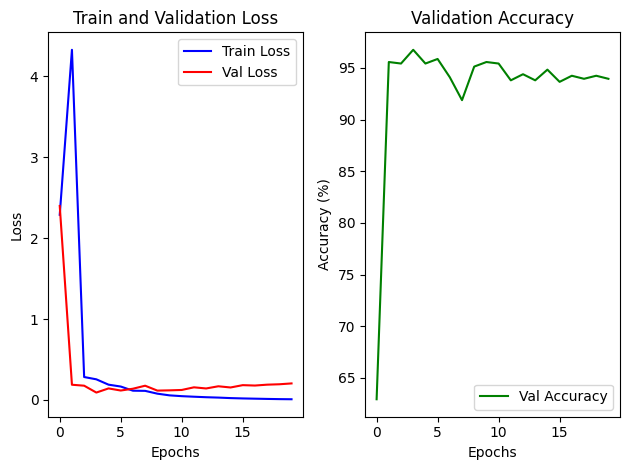

In [7]:
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss', color='blue')
plt.plot(range(epochs), val_losses, label='Val Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(range(epochs), val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.legend()

# Показать графики
plt.tight_layout()
plt.show()

In [8]:
torch.save(model, 'model_simple.pth')


In [ ]:
model = torch.load('model_simple.pth')
model.eval()

from PIL import Image
import os

def test_image(path_to_image, model, transform, dataset_classes):
    image = Image.open(path_to_image).convert('RGB')
    image = transform(image).unsqueeze(0)
    model.eval()
    output = model(image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted Class: {dataset_classes[predicted.item()]}")

def test_images_in_folder(folder_path, model, transform, dataset_classes):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if os.path.isfile(img_path):
            #print(f"Testing {img_name}:")
            test_image(img_path, model, transform, dataset_classes)


folder_path = 'Test_' 
test_images_in_folder(folder_path, model, transform, train_dataset.classes)


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class C_CNN(nn.Module):
    def __init__(self, num_classes):
        super(C_CNN, self).__init__()
        

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        

        self.fc1 = nn.Linear(16 * 112 * 112, 128) 
        self.fc2 = nn.Linear(128, num_classes) 
        

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x


num_classes = 2
model = C_CNN(num_classes)


In [ ]:
train_losses = []
val_losses = []
val_accuracies = []

epochs = 20
for epoch in range(epochs):
    # Тренировка
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))  # Средняя потеря за эпоху

    # Валидация
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Подсчет accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_losses.append(val_loss / len(val_loader))  # Средняя потеря на валидации
    val_accuracies.append(100 * correct / total)  # Accuracy на валидации

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.2f}%")


Epoch 1/20, Train Loss: 0.5567, Val Loss: 0.4690, Val Accuracy: 77.99%
Epoch 2/20, Train Loss: 0.3729, Val Loss: 0.2151, Val Accuracy: 90.55%
Epoch 3/20, Train Loss: 0.2621, Val Loss: 0.0886, Val Accuracy: 96.60%
Epoch 4/20, Train Loss: 0.1757, Val Loss: 0.0829, Val Accuracy: 97.05%
Epoch 5/20, Train Loss: 0.2321, Val Loss: 0.1539, Val Accuracy: 95.27%
Epoch 6/20, Train Loss: 0.1620, Val Loss: 0.0665, Val Accuracy: 97.34%
Epoch 7/20, Train Loss: 0.1235, Val Loss: 0.1759, Val Accuracy: 93.21%
Epoch 8/20, Train Loss: 0.1372, Val Loss: 0.0996, Val Accuracy: 96.01%
Epoch 9/20, Train Loss: 0.0497, Val Loss: 0.2927, Val Accuracy: 90.55%
Epoch 10/20, Train Loss: 0.0586, Val Loss: 0.0891, Val Accuracy: 96.75%
Epoch 11/20, Train Loss: 0.0275, Val Loss: 0.1067, Val Accuracy: 96.90%
Epoch 12/20, Train Loss: 0.0306, Val Loss: 0.1232, Val Accuracy: 97.49%

In [8]:
torch.save(model, 'model_dropout.pth')


In [18]:
import torch
model = torch.load('model_dropout.pth')

In [ ]:
from PIL import Image
import os

def test_image(path_to_image, model, transform, dataset_classes):
    image = Image.open(path_to_image).convert('RGB')
    image = transform(image).unsqueeze(0)
    model.eval()
    output = model(image)
    _, predicted = torch.max(output, 1)
    print(f"Predicted Class: {dataset_classes[predicted.item()]}")

def test_images_in_folder(folder_path, model, transform, dataset_classes):
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if os.path.isfile(img_path):
            #print(f"Testing {img_name}:")
            test_image(img_path, model, transform, dataset_classes)


folder_path = 'Negative_t' 
test_images_in_folder(folder_path, model, transform, train_dataset.classes)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n-cls.pt')  # load a pretrained model (recommended for training)

model.train(data='C:/Users/nurtu/OneDrive/Рабочий стол/final_project/dataset',
            epochs=10, imgsz=640)
